# Title

In [1]:
"""markdown
    TITLE   :
    AUTHOR  :
    PROJECT :
""";

__author__ = ''
__version__ = ''

<br><br>

- - - 
- - - 


# Prepare

## Imports

In [3]:
from astroPHD import ipython
ipython.run_imports(base=True, astropy=True, matplotlib=True, verbose_imports=False)

from scipy import optimize

from astropy.stats import histogram

import seaborn as sns

# GENERAL

# CUSTOM

# PROJECT-SPECIFIC

sys.path.insert(0, '../')
import src
from src import (
    convert_angle, convert_pm_angular,
    load_summary_table, load_globular_cluster,
    GlobularCluster
)
from src import plot
from src.utils import profile_binning
from src.GMM import GMM, GMM_bins
# from src.modeling import vel_disp_profile
from src.plot import colorbar_non_mappable
from src.util.gaussfitter import gaussfit, twodgaussian

<br><br>

- - - 
- - - 


# Code

In [38]:
drct = "../data/"
gc_name = "Pal_6"
# gc_name = "NGC_104_47Tuc"
# gc_name = "IC_1257"

GC = GlobularCluster.from_directory(gc_name, drct)

In [39]:
from astropy.stats import SigmaClip

In [40]:
sigclip = SigmaClip(sigma=4, maxiters=1.)
resx = sigclip(GC.pmx)
resy = sigclip(GC.pmy)

pmx = resx.data[~resx.mask & ~resy.mask]
pmy = resy.data[~resx.mask & ~resy.mask]

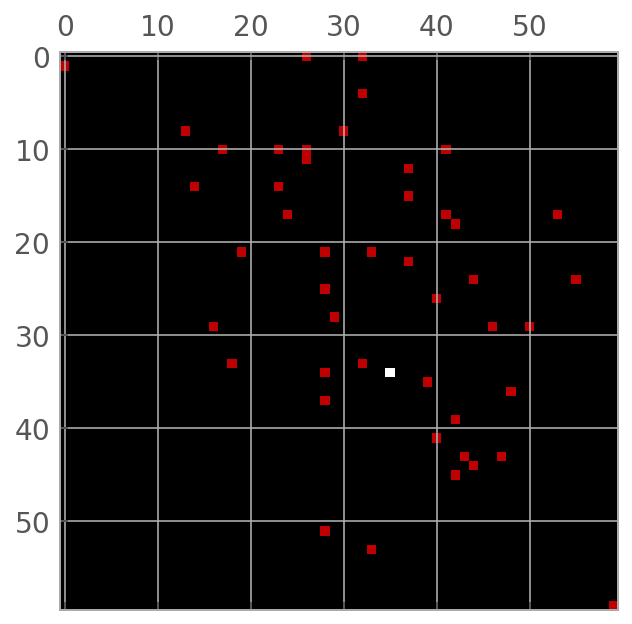

In [41]:
data, *edges = np.histogram2d(GC.pmx, GC.pmy, bins=60, density=True)
plt.matshow(data)

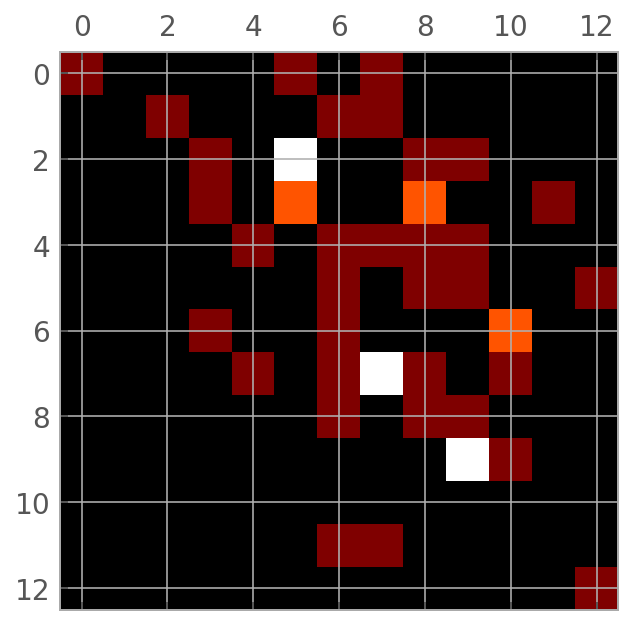

In [42]:
# plt.figure(figsize=(10,10))
# plt.hist2d(GC.pmx, GC.pmy, bins=20, norm=colors.LogNorm());
data, *edges = np.histogram2d(pmx, pmy, bins=int(1 + 3.222 * np.log(len(pmx))), density=True)
plt.matshow(data)

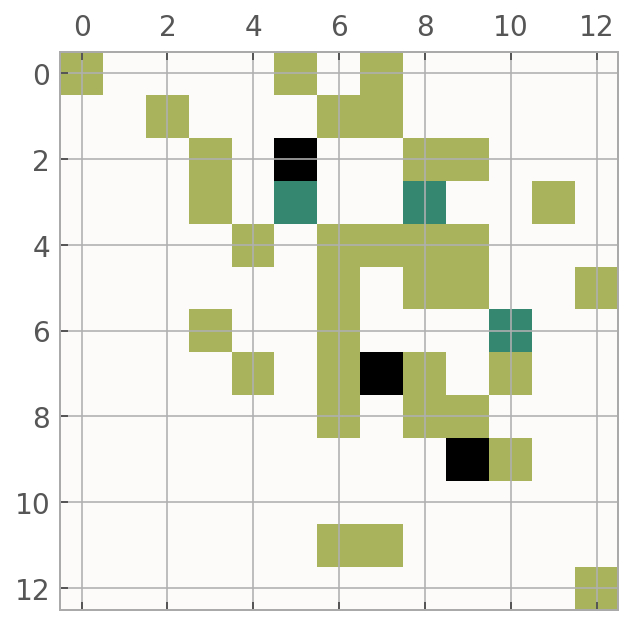

In [43]:
plt.matshow(data, cmap=plt.cm.gist_earth_r)

## Normality Tests

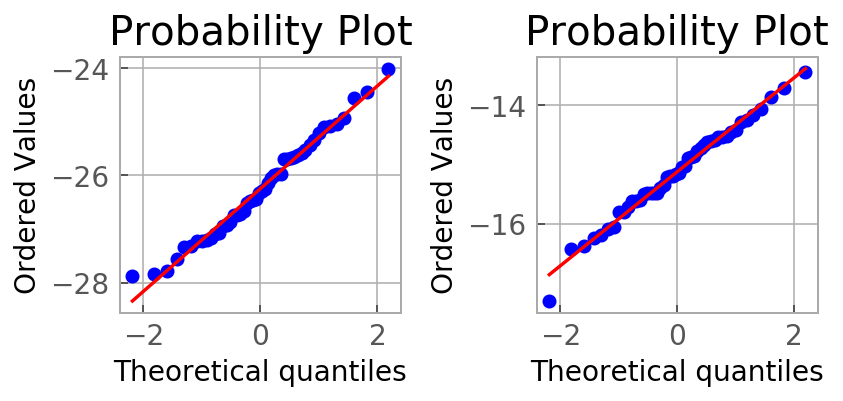

In [44]:
import numpy as np 
import scipy.stats as stats

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 3))
stats.probplot(pmx, dist="norm", plot=ax0)
stats.probplot(pmy, dist="norm", plot=ax1)
plt.tight_layout();

It's not a perfect Gaussian, the wings are wrong

### Anderson Darling

In [45]:
res = stats.anderson(pmx, dist='norm')
res

AndersonResult(statistic=0.26870453732165345, critical_values=array([0.537, 0.612, 0.734, 0.856, 1.018]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

It is not normal.

In [46]:
res = stats.kstest(pmx, 'norm')
res

KstestResult(statistic=1.0, pvalue=0.0)

### 2D version

In [47]:
pm = np.sqrt(pmx**2 + pmy**2)


In [48]:
df, loc, scale = stats.chi2.fit(pm)
df, loc, scale

(261.1471654257354, 18.273270342743956, 0.04602239472931843)

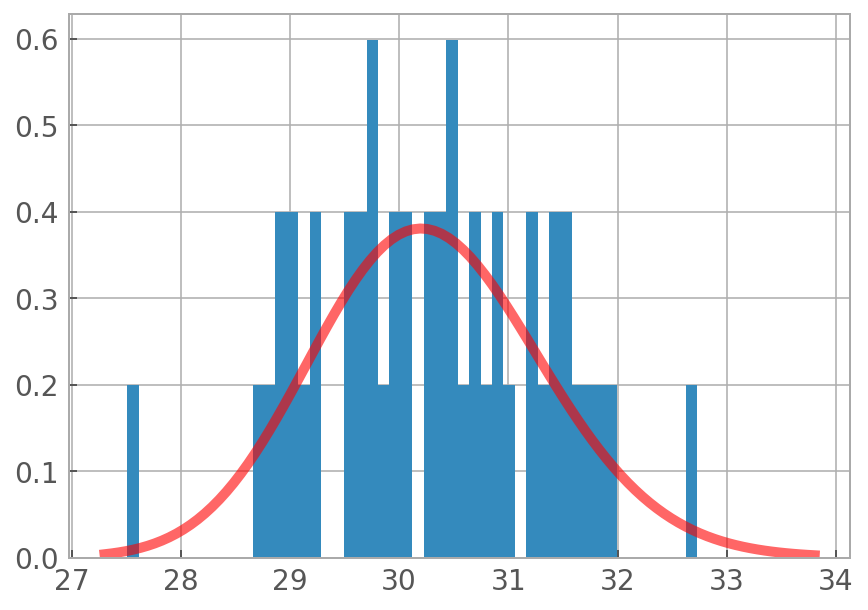

In [49]:
plt.hist(pm, bins=50, density=True);
x = np.linspace(stats.chi2.ppf(0.001, df, loc, scale),
                stats.chi2.ppf(0.999, df, loc, scale), 100)
plt.plot(x, stats.chi2.pdf(x, df, loc, scale),
        'r-', lw=5, alpha=0.6, label='chi2 pdf');

((array([28.10784   , 28.4550718 , 28.66415282, 28.82000021, 28.94736635,
         29.05684827, 29.15402577, 29.24222398, 29.32359727, 29.3996291 ,
         29.47138998, 29.53968189, 29.60512473, 29.6682106 , 29.72933951,
         29.78884366, 29.8470045 , 29.90406509, 29.96023925, 30.0157186 ,
         30.07067802, 30.12528011, 30.17967893, 30.23402321, 30.28845928,
         30.34313388, 30.39819693, 30.45380443, 30.51012169, 30.56732694,
         30.62561571, 30.68520609, 30.74634543, 30.80931893, 30.87446107,
         30.94217107, 31.01293441, 31.0873536 , 31.16619365, 31.25045156,
         31.3414673 , 31.44111034, 31.55211422, 31.67872878, 31.82814356,
         32.014145  , 32.26934244, 32.7081748 ]),
  array([27.50969472, 28.75450955, 28.85173092, 28.88144585, 28.90705948,
         28.99153069, 29.03672509, 29.16879472, 29.2014274 , 29.20216634,
         29.54302661, 29.55939802, 29.64469061, 29.64769503, 29.71306991,
         29.73882405, 29.76987317, 29.8426847 , 29.99146898, 2

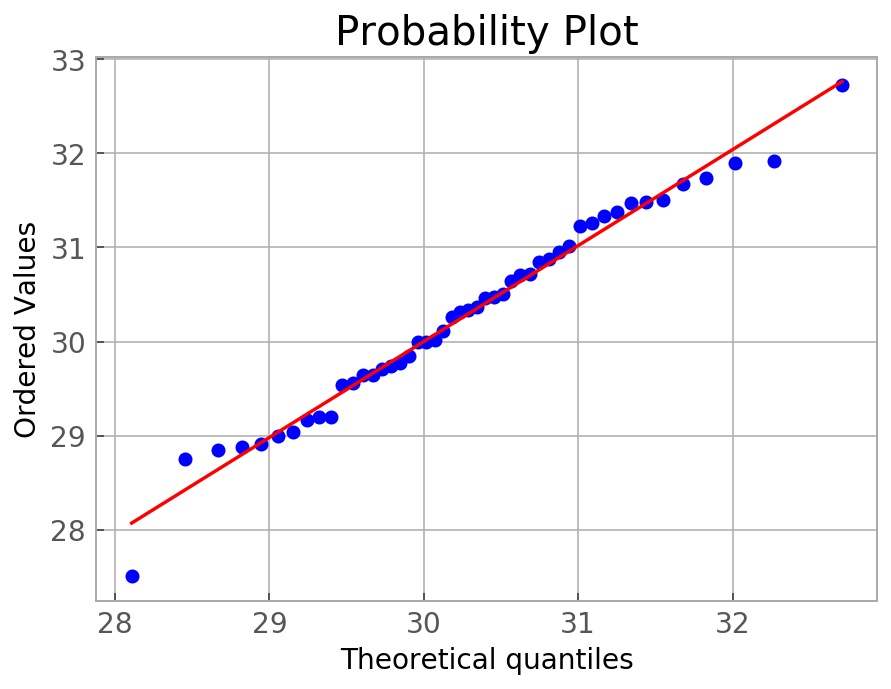

In [50]:
stats.probplot(pm, dist=stats.chi2(df, loc, scale), plot=plt)

## 2D Gaussian Fit with Rotation

In [51]:
# TODO error estimate from bin size
params, cov, infodict, errmsg = gaussfit(data, circle=0, rotate=1, vheight=1, return_all=True)
print(errmsg)

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


Text(0.95,0.05,'\nx : 4.6\ny : 7.0\nrot : 154.1\nwidth_x : 4.5\nwidth_y : 2.2')

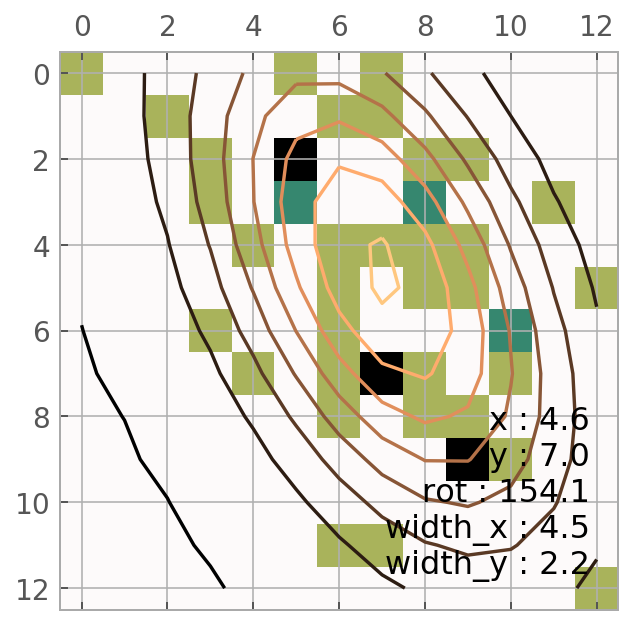

In [52]:
plt.matshow(data, cmap=plt.cm.gist_earth_r)

fit = twodgaussian(params, circle=0, rotate=1, vheight=1)
plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, amp, x, y, width_x, width_y, rota) = params

rota %= 360  # shift back to 0 - 360 degree rotation

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
rot : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, rota, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


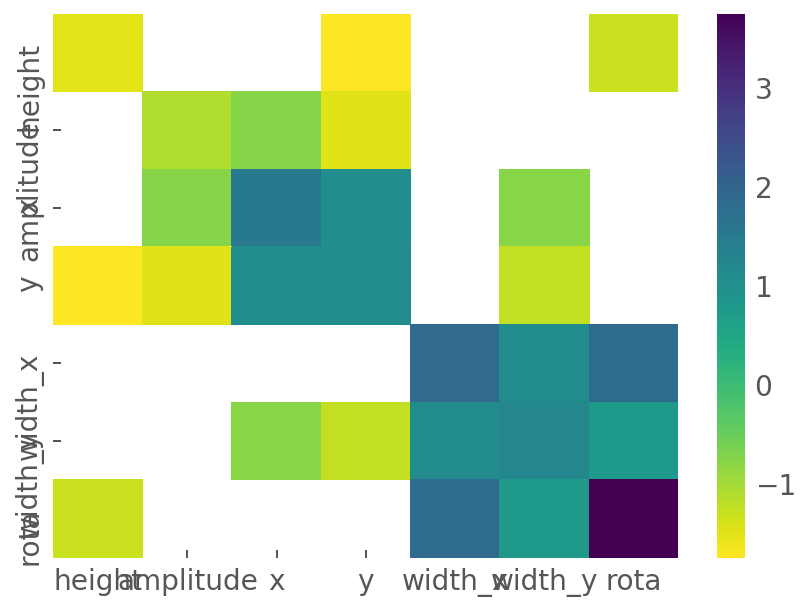

In [53]:
# (height, amplitude, x, y, width_x, width_y, rota)
sns.heatmap(np.log10(cov), cmap='viridis_r')
labels = 'height amplitude x y width_x width_y rota'.split()
plt.xticks(plt.xticks()[0], labels)
plt.yticks(plt.yticks()[0], labels);

It makes no real difference to the derived parameters, but just adds confusion. So sticking to the simpler model

## Gaussian Fit with no Rotation

https://scipy-cookbook.readthedocs.io/items/FittingData.html

In [54]:
# https://scipy-cookbook.readthedocs.io/items/FittingData.html

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, cov, infodict, *errmsg = optimize.leastsq(errorfunction, params, full_output=True)
    return p, cov, infodict, errmsg

Text(0.95,0.05,'\nx : 4.7\ny : 7.2\nwidth_x : 3.9\nwidth_y : 2.6')

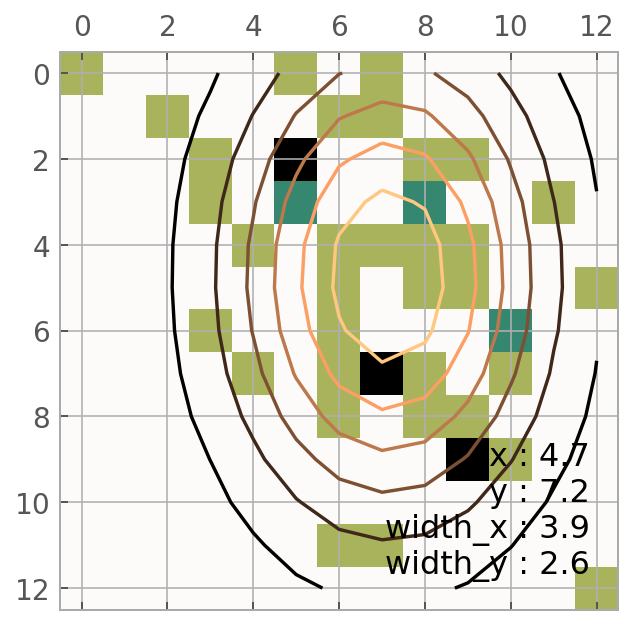

In [55]:
plt.matshow(data, cmap=plt.cm.gist_earth_r)

params, cov, infodict, errmsg = fitgaussian(data)
fit = gaussian(*params)

plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


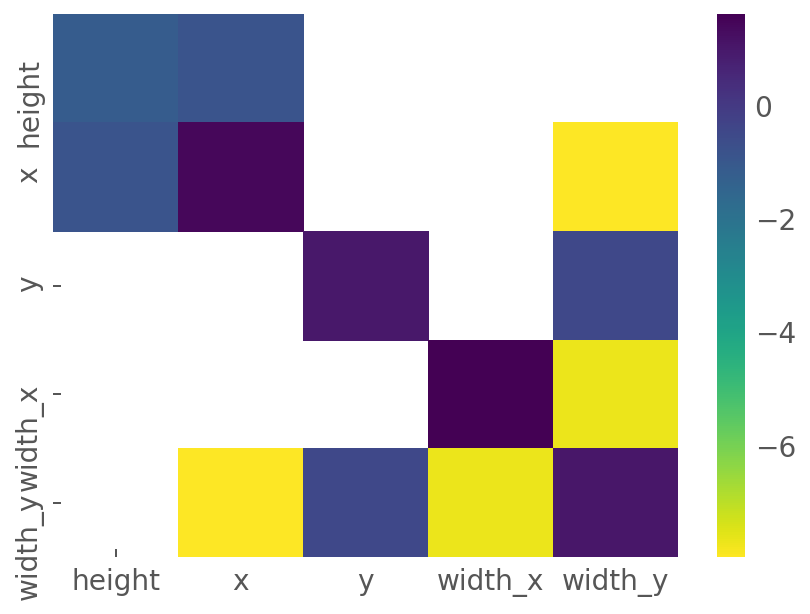

In [56]:
# (height, amplitude, x, y, width_x, width_y, rota)
sns.heatmap(np.log10(cov), cmap='viridis_r')
labels = 'height x y width_x width_y'.split()
plt.xticks(plt.xticks()[0], labels)
plt.yticks(plt.yticks()[0], labels);

## Approximate Scale Parameter

Note this assumed approximate normality

Start with the scale in bin-space

In [57]:
bin_pm_scale = (width_x + width_y) / 2

Now convert to real-space

In [58]:
x_edges, y_edges = edges

In [59]:
np.allclose(np.diff(x_edges)[:-1], np.diff(x_edges)[1:])
np.allclose(np.diff(y_edges)[:-1], np.diff(y_edges)[1:])
np.allclose(np.diff(x_edges), np.diff(y_edges), rtol=5e-2)

True

True

True

The bins are all the same size, so the conversion factor is 

In [60]:
pm_per_bin = np.diff(x_edges)[0] * u.mas/u.yr

In [61]:
pm_scale = bin_pm_scale * pm_per_bin

error estimate

In [62]:
pm_scale_err = np.abs((width_x - width_y) / 2) * pm_per_bin

In [63]:
print(f"{pm_scale.value:.3f} +/- {pm_scale_err:.3f}")

0.958 +/- 0.200 mas / yr


# Plummer Model

<br><br>

- - - 
- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>